In [19]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as graph
import seaborn as sns
from IPython.display import display, HTML, Markdown, Math, Latex

from AssignmentThreeFunctions import get_parent_offspring_data, get_qtl_data, \
init_trait_data, init_qtl_marker_data, select_by_markers, assessing_marker_importance 

sns.set(font_scale=1.5)
sns.set_style('ticks')

%matplotlib inline

# Part 1: Narrow Sense Heritability

**Question 1**: Estimate narrow-sense heritability for the four traits. [DONE]

**Question 2**: Discuss the relevance of genes vs environment in affecting the studied traits. *In a few sentences.*

In [20]:
raw_data = get_parent_offspring_data()

# Trait 1
trait_1 = init_trait_data(trait='t1')

# Trait 2
trait_2 = init_trait_data(trait='t2')

# Trait 3
trait_3 = init_trait_data(trait='t3')

# Trait 4
trait_4 = init_trait_data(trait='t4')

Rsq    : 0.3647773700676612
Adj Rsq: 0.34209084757007757


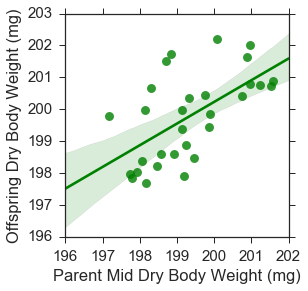

Rsq    : 0.1077840329787787
Adj Rsq: 0.07591917701373496


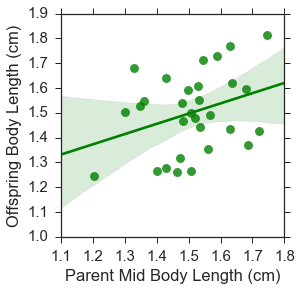

Rsq    : 0.21902450015323527
Adj Rsq: 0.19113251801585074


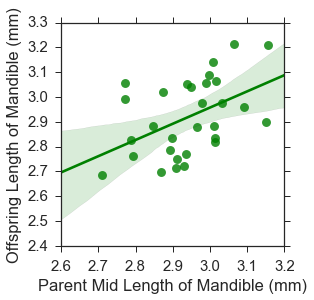

Rsq    : 0.004901231862352251
Adj Rsq: -0.030638009856849502


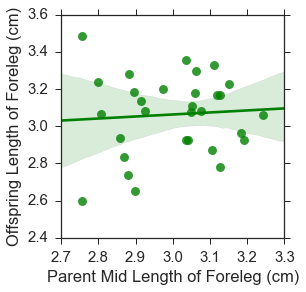

In [21]:
# Parent Offspring Regressions (OLS Regression)
from pandas.stats.api import ols

traits = [trait_1, trait_2, trait_3, trait_4]
names = ['Dry Body Weight (mg)', 'Body Length (cm)', 'Length of Mandible (mm)', 'Length of Foreleg (cm)']

for i, trait in enumerate(traits):
    display(HTML('<hr><h2>Trait {}: {}</h2>'.format(i + 1, names[i])))
    
    # Compute heritability
    results = ols(x=trait['parent_mid'], y=trait['offspring'])
    
    # Quick Stats
    output = 'Heritability: {} p: {}'.format(round(results.beta['x'], 4), round(results.p_value['x'], 4))
    if results.p_value['x'] <= 0.05:
        display(HTML('<strong><h4>SIGNIFICANT<br/>{}*</h4></strong>'.format(output)))
    else:
        display(HTML('<h4>{}</h4>'.format(output)))
        
    print('Rsq    : {}'.format(results.r2))
    print('Adj Rsq: {}'.format(results.r2_adj))
            
    # Graph Regression to the mean
    graph.figure(figsize=(4, 4))
    sns.regplot(x=trait['parent_mid'], y=trait['offspring'], color='g', scatter_kws={'s': 80, 'edgecolor': 'k'})
    graph.xlabel('Parent Mid {}'.format(names[i]))
    graph.ylabel('Offspring {}'.format(names[i]))
    graph.show()
    
    # Output Comprehensive Results
    # print(results)

# Part 2: QTL Analysis

**Question 3**: Naive QTL analysis to determine how many QTLs affect the trait and where they are on the genetic map. *No regression graphs!* [DONE]

**Question 4**: Discuss the relative effects of the identified QTL alleles on horn size? Do QTL allele effect sizes reflect differences between the Short Horn and Long Horn inbred lines?

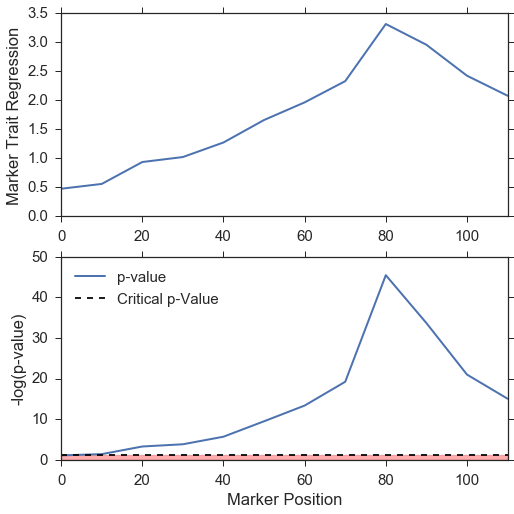

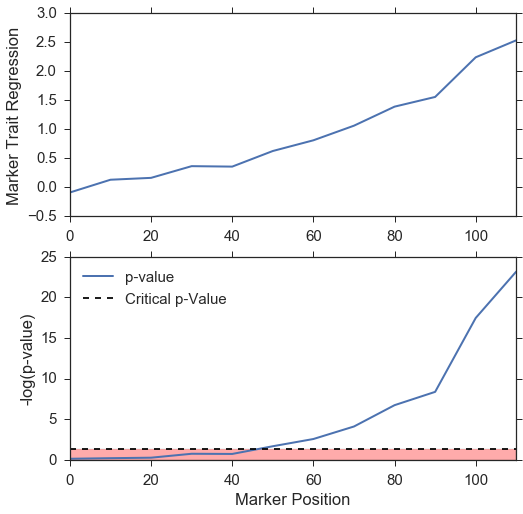

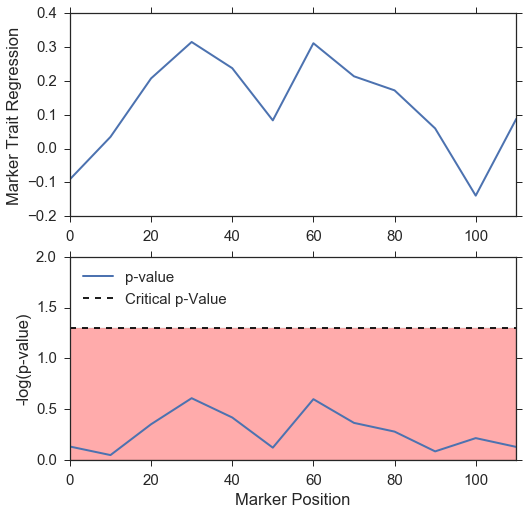

In [22]:
# Calculate the loci QTL Data
chromosome_1 = init_qtl_marker_data(chromosome='MK-1')
chromosome_2 = init_qtl_marker_data(chromosome='MK-2')
chromosome_3 = init_qtl_marker_data(chromosome='MK-3')

chromosomes = [chromosome_1, chromosome_2, chromosome_3]
critical_value = 0.05

for i, chromo in enumerate(chromosomes):
    display(HTML('<hr><h2>Chromosome {}</h2>'.format(i+1)))
    
    chromo['p-crit'] = critical_value
    
    graph.figure(figsize=(8,8))
    
    graph.subplot(211)
    graph.plot(chromo['Position'], chromo['Slope'], linewidth=2)
    graph.ylabel('Marker Trait Regression')
    graph.xlim([0, 110])
    
    graph.subplot(212)
    graph.plot(chromo['Position'], -np.log10(chromo['p-value']), linewidth=2)
    graph.plot(chromo['Position'], -np.log10(chromo['p-crit']), linestyle='--', c='black', label='Critical p-Value')
    graph.fill_between(chromo['Position'], 0, -np.log10(chromo['p-crit']), facecolor='red', alpha='0.33')
    graph.legend(loc='upper left')
    graph.xlabel('Marker Position')
    graph.ylabel('-log(p-value)')
    graph.xlim([0, 110])
    if chromo['p-value'].min() > 0.05:
        graph.ylim(ymax=2)
    
    graph.show()

# Predicting Phenotype from Genotype

Even though the markers are must likely not the gene responsible for the phenotype it is still very likely that, due to linkage, we could predict phenotype from the genotypes of the QTLs.

For my dataset their appears to only be 2 QTLs. While I should still be able to make predictions the confidence intervals might be too large to be useful.

Those markers are 
- MK-1-9
- MK-2-12

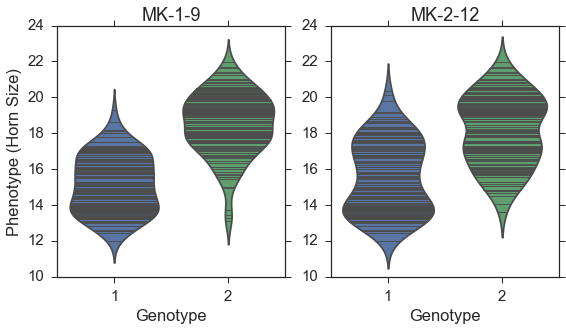

In [23]:
# Get suspected QTLs for the regression model.
markers = ['MK-1-9', 'MK-2-12']
data = select_by_markers(markers)

x = np.array(data[markers].values.tolist())
y = np.array(data['phenotype'].values.tolist())

# Data Exploration
graph.figure(figsize=(9, 4.5))

graph.subplot(121)
graph.title(markers[0])
sns.violinplot(x=data[markers[0]], y=data['phenotype'], inner='stick')
graph.xlabel('Genotype')
graph.ylabel('Phenotype (Horn Size)')

graph.subplot(122)
graph.title(markers[1])
sns.violinplot(x=data[markers[1]], y=data['phenotype'], inner='stick')
graph.xlabel('Genotype')
graph.ylabel('')

graph.show()

This data looks good for MLRs but I'll make a K-NN Model just in case.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

# Models
simple_linear_regression = LinearRegression()
simple_linear_regression.fit(x_train, y_train)

parameters = [
    {
        'n_neighbors': np.arange(start=1, stop=150, step=2, dtype=int)
    }
]
knn_grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=parameters, cv=5, n_jobs=-1)
knn_grid_search = knn_grid_search.fit(x_train, y_train)
knn_regression = knn_grid_search.best_estimator_

# Validate Models
linear_regression_error = mean_squared_error(y_test, simple_linear_regression.predict(x_test))
knn_regression_error = mean_squared_error(y_test, knn_regression.predict(x_test))

def print_metrics(mse, r_sq, parameters):
    print('R_sq: {}'.format(round(r_sq, 3)))
    print('MSE: {}'.format(round(mse, 3)))
    print('Parameters: {}'.format(parameters))
    print('')

print('Linear Regression')
print('Coefs: ', simple_linear_regression.coef_)
print('Intercept: ', simple_linear_regression.intercept_)
print_metrics(linear_regression_error, simple_linear_regression.score(x_test, y_test), simple_linear_regression.get_params())

print('K-NN Regression')
print_metrics(knn_regression_error, knn_regression.score(x_test, y_test), knn_regression.get_params())

Linear Regression
Coefs:  [ 3.07639623  2.15968948]
Intercept:  8.93362153449
R_sq: 0.757
MSE: 1.282
Parameters: {'fit_intercept': True, 'n_jobs': 1, 'normalize': False, 'copy_X': True}

K-NN Regression
R_sq: 0.755
MSE: 1.291
Parameters: {'metric_params': None, 'weights': 'uniform', 'p': 2, 'algorithm': 'auto', 'n_jobs': 1, 'metric': 'minkowski', 'leaf_size': 30, 'n_neighbors': 29}



## MLR Model for Horn Size

The MLR Model gives great results like I thought it would so let's                 visualise the total effect now to see how these genes interact with each other.

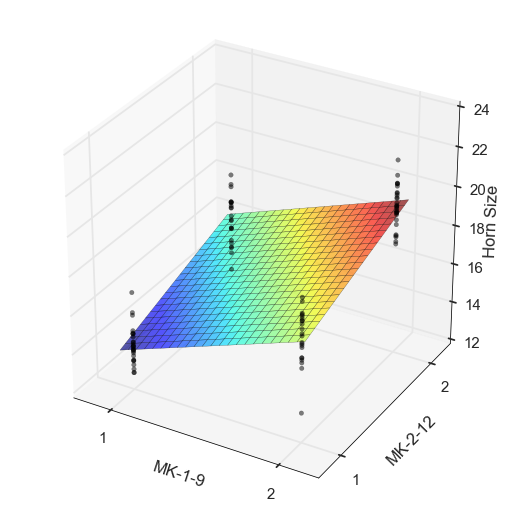

In [25]:
# Uncomment to allow rotation
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D

sns.set_style('ticks')

display(Markdown('## MLR Model for Horn Size'))
display(Markdown('The MLR Model gives great results like I thought it would so let\'s\
                 visualise the total effect now to see how these genes interact with each other.'))

figure_3d = graph.figure(figsize=(9, 9))
ax_3d = figure_3d.gca(projection='3d')

ax_3d.scatter(x_test[:, 0], x_test[:, 1], y_test, c='black', alpha=0.5)

xx1, xx2 = np.meshgrid(np.arange(0.95, 2.05, 0.005), np.arange(0.95, 2.05, 0.005))
horn_size_predicted = simple_linear_regression.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
horn_size_predicted = horn_size_predicted.reshape(xx1.shape)
horn_surface = ax_3d.plot_surface(xx1, xx2, horn_size_predicted, cmap=graph.cm.jet, alpha= 0.66)

ax_3d.set_xticks([1, 2])
ax_3d.set_yticks([1, 2])

ax_3d.set_xlabel(markers[0])
ax_3d.set_ylabel(markers[1])
ax_3d.set_zlabel('Horn Size')

figure_3d.show()

## k-NN Regression Model for Horn Size

I always wanted to use k-NN models because ituitively it              captures the discrete nature of effects of genetic differences.

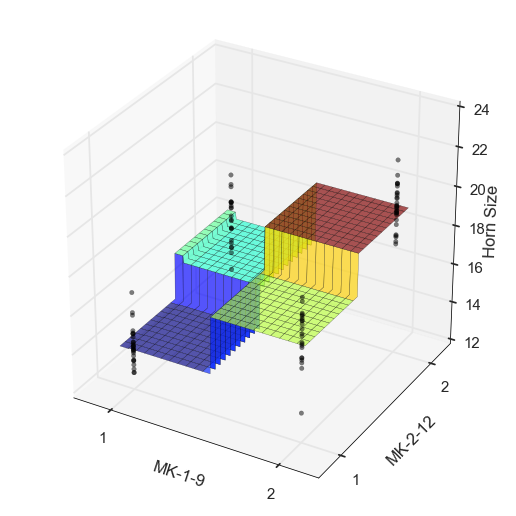

In [26]:
# Uncomment to allow rotation
#%matplotlib qt

display(Markdown('## k-NN Regression Model for Horn Size'))
display(Markdown('I always wanted to use k-NN models because ituitively it \
             captures the discrete nature of effects of genetic differences.'))

figure_3d = graph.figure(figsize=(9, 9))
ax_3d = figure_3d.gca(projection='3d')

ax_3d.scatter(x_test[:, 0], x_test[:, 1], y_test, c='black', alpha=0.5)

xx1, xx2 = np.meshgrid(np.arange(0.95, 2.05, 0.005), np.arange(0.95, 2.05, 0.005))
horn_size_predicted = knn_regression.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
horn_size_predicted = horn_size_predicted.reshape(xx1.shape)
horn_surface = ax_3d.plot_surface(xx1, xx2, horn_size_predicted, cmap=graph.cm.jet, alpha= 0.66)

ax_3d.set_xticks([1, 2])
ax_3d.set_yticks([1, 2])

ax_3d.set_xlabel(markers[0])
ax_3d.set_ylabel(markers[1])
ax_3d.set_zlabel('Horn Size')

figure_3d.show()

## Assessing Marker Importance

I'm using a Random Forest model to estimate each other the marker's influence on the variance explained

- 1) **MK-1-9** 70.27%

- 2) **MK-2-12** 29.73%

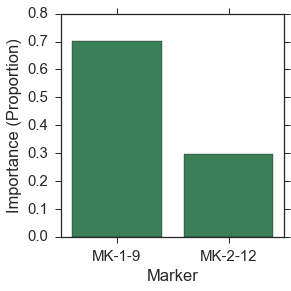

In [27]:
# Feature Importance
display(Markdown('## Assessing Marker Importance'))
display(Markdown('I\'m using a Random Forest model to estimate each other the marker\'s influence on the variance explained'))

marker_importance, data_frame = assessing_marker_importance(x_train, y_train, markers)

for line in marker_importance:
    display(Markdown('- {}'.format(line)))
    
graph.figure(figsize=(4, 4))
sns.barplot(x=data_frame['Marker'], y=data_frame['Importance'], color='seagreen')
graph.ylabel('Importance (Proportion)')
graph.show()